# Modules Importation and File Reading

I am going to use pandas for data cleaning and transformation, matplotlib and seaborn for visualization and other additional libraries to help me explore through the data like datetime.

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt, time

### Importing the Data

In [76]:
df = pd.read_csv("upi_transactions_2024.csv")
df.head()

,transaction id,timestamp,transaction type,merchant_category,amount (INR),transaction_status,sender_age_group,receiver_age_group,sender_state,sender_bank,receiver_bank,device_type,network_type,fraud_flag,hour_of_day,day_of_week,is_weekend
0,TXN0000000001,2024-10-08 15:17:28,P2P,Entertainment,868,SUCCESS,26-35,18-25,Delhi,Axis,SBI,Android,4G,0,15,Tuesday,0
1,TXN0000000002,2024-04-11 06:56:00,P2M,Grocery,1011,SUCCESS,26-35,26-35,Uttar Pradesh,ICICI,Axis,iOS,4G,0,6,Thursday,0
2,TXN0000000003,2024-04-02 13:27:18,P2P,Grocery,477,SUCCESS,26-35,36-45,Karnataka,Yes Bank,PNB,Android,4G,0,13,Tuesday,0
3,TXN0000000004,2024-01-07 10:09:17,P2P,Fuel,2784,SUCCESS,26-35,26-35,Delhi,ICICI,PNB,Android,5G,0,10,Sunday,1
4,TXN0000000005,2024-01-23 19:04:23,P2P,Shopping,990,SUCCESS,26-35,18-25,Delhi,Axis,Yes Bank,iOS,WiFi,0,19,Tuesday,0


### Cleaning the data

I use:
- `.info()` understand the data.

- `.nunique()` to see the number of unique values in every column of our dataset.

- `.shape` to see the number of rows and columns that we have.

- `.drop_duplicates()` to drop any repeated transaction rows. (None were found)

In [77]:
df.info()
df.nunique()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   transaction id      250000 non-null  object
 1   timestamp           250000 non-null  object
 2   transaction type    250000 non-null  object
 3   merchant_category   250000 non-null  object
 4   amount (INR)        250000 non-null  int64 
 5   transaction_status  250000 non-null  object
 6   sender_age_group    250000 non-null  object
 7   receiver_age_group  250000 non-null  object
 8   sender_state        250000 non-null  object
 9   sender_bank         250000 non-null  object
 10  receiver_bank       250000 non-null  object
 11  device_type         250000 non-null  object
 12  network_type        250000 non-null  object
 13  fraud_flag          250000 non-null  int64 
 14  hour_of_day         250000 non-null  int64 
 15  day_of_week         250000 non-null  object
 16  is

(250000, 17)

Confirm that the columns that seem to have the unique categories actually have all unique categories without data inconsistency in those columns. We have 17 columns and 250,000 rows of data with the ones that are supposed to have unique values having consistent data.

In [78]:
all_cols = df.nunique().to_frame()
columns_to_check = {"items": [item[0]for item in [(df.loc[:, index].unique(), key[0])for index, key in all_cols.iterrows() if key[0] <= 10]] ,
                    "item_count": [item[1] for item in [(df.loc[:, index].unique(), key[0])for index, key in all_cols.iterrows() if key[0] <= 10]]}
pd.DataFrame(columns_to_check)

,items,item_count
0,"[P2P, P2M, Bill Payment, Recharge]",4
1,"[Entertainment, Grocery, Fuel, Shopping, Food,...",10
2,"[SUCCESS, FAILED]",2
3,"[26-35, 36-45, 46-55, 56+, 18-25]",5
4,"[18-25, 26-35, 36-45, 46-55, 56+]",5
5,"[Delhi, Uttar Pradesh, Karnataka, Telangana, M...",10
6,"[Axis, ICICI, Yes Bank, IndusInd, HDFC, Kotak,...",8
7,"[SBI, Axis, PNB, Yes Bank, IndusInd, HDFC, Kot...",8
8,"[Android, iOS, Web]",3
9,"[4G, 5G, WiFi, 3G]",4


The data in the 13 identified columns is consistent

In [79]:
# pd.set_option('display.max_colwidth', None)

Check for any duplicated rows. No duplicated rows are present.

In [80]:
df[df.duplicated()]

,transaction id,timestamp,transaction type,merchant_category,amount (INR),transaction_status,sender_age_group,receiver_age_group,sender_state,sender_bank,receiver_bank,device_type,network_type,fraud_flag,hour_of_day,day_of_week,is_weekend


In [81]:
df.describe()

,amount (INR),fraud_flag,hour_of_day,is_weekend
count,250000.000000,250000.000000,250000.000000,250000.000000
mean,1311.756036,0.001920,14.681032,0.285348
std,1848.059224,0.043776,5.188304,0.451581
min,10.000000,0.000000,0.000000,0.000000
25%,288.000000,0.000000,11.000000,0.000000
50%,629.000000,0.000000,15.000000,0.000000
75%,1596.000000,0.000000,19.000000,1.000000
max,42099.000000,1.000000,23.000000,1.000000


In [82]:
# Understanding the years and the months the data covers
pd.to_datetime(df["timestamp"]).dt.year.unique(), len(pd.to_datetime(df["timestamp"]).dt.month.unique())

# Our data covers the year 2024 and all the months in it.

(array([2024]), 12)

#  Analysing the Data
I start by visualizing the total amounts spent every hour throughout the year and there seems to be a trend as seen in the visualization below:

1. The general trend is, the transactions count begin decreasing from 0000hrs and begin rising at around 0500hrs. The transactions count continue increasing up until midday then they start decreasing again up until 1400hrs where they begin rising again. They keep rising up until 1900hrs where they then keep decreasing till 2300hrs.

<Axes: xlabel='hour_of_day'>

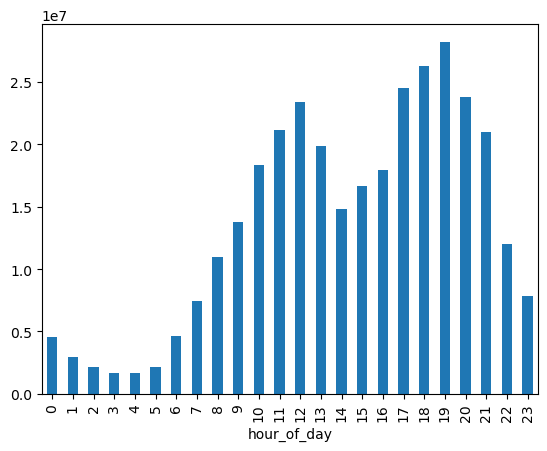

In [83]:
total_spending_by_hour = df.groupby("hour_of_day")["amount (INR)"].sum()
total_spending_by_hour.plot(kind="bar")

I proceed to visualize the average amounts spent every hour to  help me determine if the average spending amounts differ by much in all the hours. 

The result as seen below shows that the averages are almost the same hence a conclusion that the trend identified in the previous plot is one to be considered as the actual daily habit spend as far as the transactions are concerned.

hour_of_day
0     1337.923259
1     1298.729947
2     1290.059347
3     1277.525875
4     1339.775461
5     1225.098737
6     1318.775778
7     1329.088099
8     1315.081327
9     1321.437416
10    1318.851625
11    1297.964294
12    1336.279973
13    1319.844328
14    1294.335861
15    1319.561470
16    1280.812250
17    1336.651363
18    1310.664573
19    1329.291729
20    1287.258943
21    1291.791731
22    1286.931226
23    1346.127729
Name: amount (INR), dtype: float64

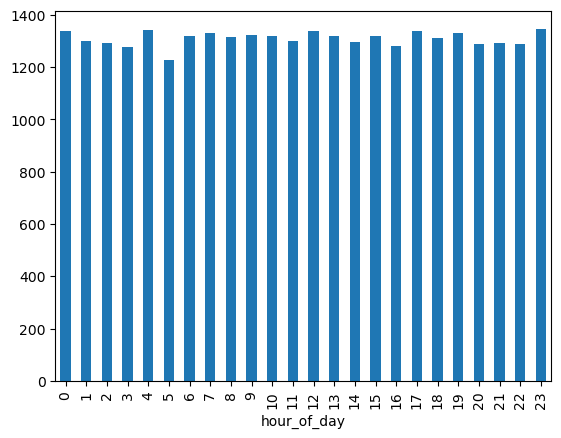

In [84]:
average_spending_by_hour = df.groupby("hour_of_day")["amount (INR)"].mean(numeric_only=True)
average_spending_by_hour.plot(kind="bar")
average_spending_by_hour

Visualizing whether there are any outliers in the whole dataset, by hour, that we may want to investigate and too know where they fall.

Do they affect the the total amounts of the plots we have above?
Do they affect the averages?

Findings:
There are many outliers in all the hours.

Conclusion:
- The results of the total amount and average amounts spent are heavily affected by the outliers since number of transactions above the top point of the boxplot below are many and the spread between the boxplot and the outliers progressively increase to large amounts.

This tells me that the averages I got from the above plot are far beyond what most people in india spend and I want to know the actual average amount that the people in India Spend. We'll do that by finding the median to have a general view what ranges a person in india spends.

<Axes: xlabel='hour_of_day', ylabel='amount (INR)'>

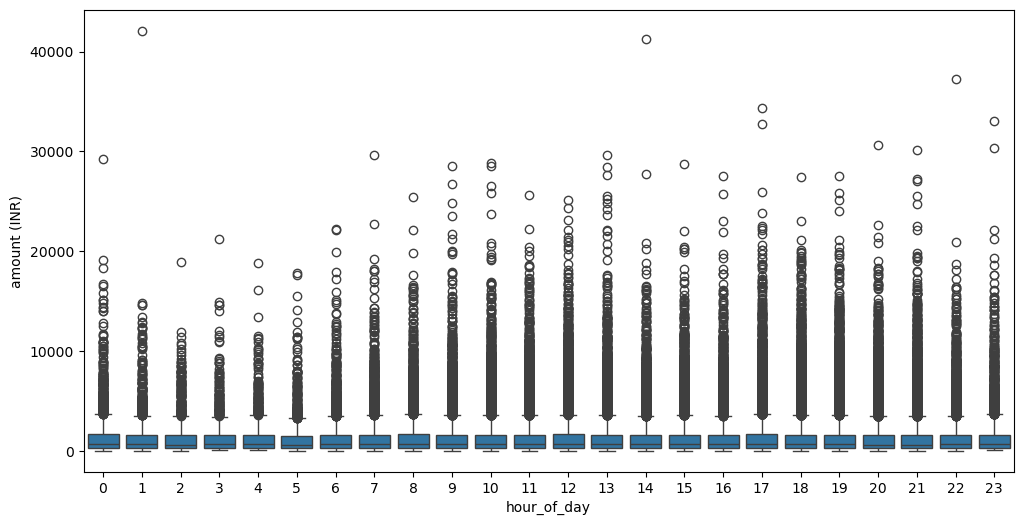

In [85]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[["hour_of_day", "amount (INR)"]], x="hour_of_day", y="amount (INR)")


General view of the average amounts a person in India spends first, generally, and secondly, by hour.

The general spend for an average person in India falls between `585-655 INR`. The average is `628 INR`.

Also note how the count in transactions matches the plot on the `total amount spent` which tells us that the plot of the total amount spent is also supported by transaction count. The quality of the total amount spent plot is validated by the `average_spending_by_hour.plot(kind="bar")` plot above.

,0
amount (INR),627.9375


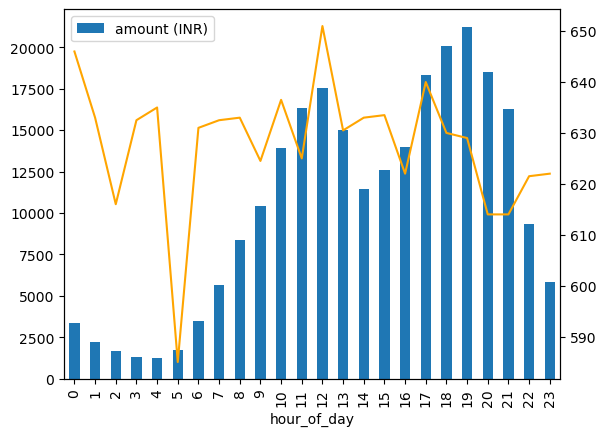

In [86]:
general_spent_amount = df[["amount (INR)"]].median().to_frame()
average_range_amount_spent_by_hour = df[["hour_of_day", "amount (INR)"]].groupby("hour_of_day").count()
count_plot = average_range_amount_spent_by_hour.plot(kind="bar")

average_range_amount_spent_by_hour = df[["hour_of_day", "amount (INR)"]].groupby("hour_of_day").median()

count_median_plot = count_plot.twinx()
count_median_plot.plot(average_range_amount_spent_by_hour, color='orange')

average_median = average_range_amount_spent_by_hour.mean()
average_median.to_frame()


### Analysing the Product Categories

In [87]:
df2 = df
df2.columns

Index(['transaction id', 'timestamp', 'transaction type', 'merchant_category',
       'amount (INR)', 'transaction_status', 'sender_age_group',
       'receiver_age_group', 'sender_state', 'sender_bank', 'receiver_bank',
       'device_type', 'network_type', 'fraud_flag', 'hour_of_day',
       'day_of_week', 'is_weekend'],
      dtype='object')

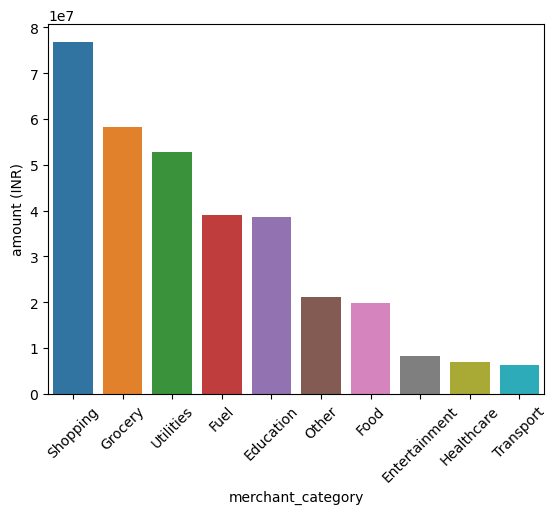

In [88]:
overall_product_performance = df2.groupby("merchant_category")["amount (INR)"].sum().to_frame().sort_values("amount (INR)", ascending=False)
sns.barplot(data=overall_product_performance, x="merchant_category", y="amount (INR)", hue="merchant_category")
_ = plt.xticks(rotation=45)

The top 3 best performing product categories are: `shopping`, `grocery` and `utilities`. Let's find out if they lead in sales every hour.

<Axes: xlabel='hour_of_day'>

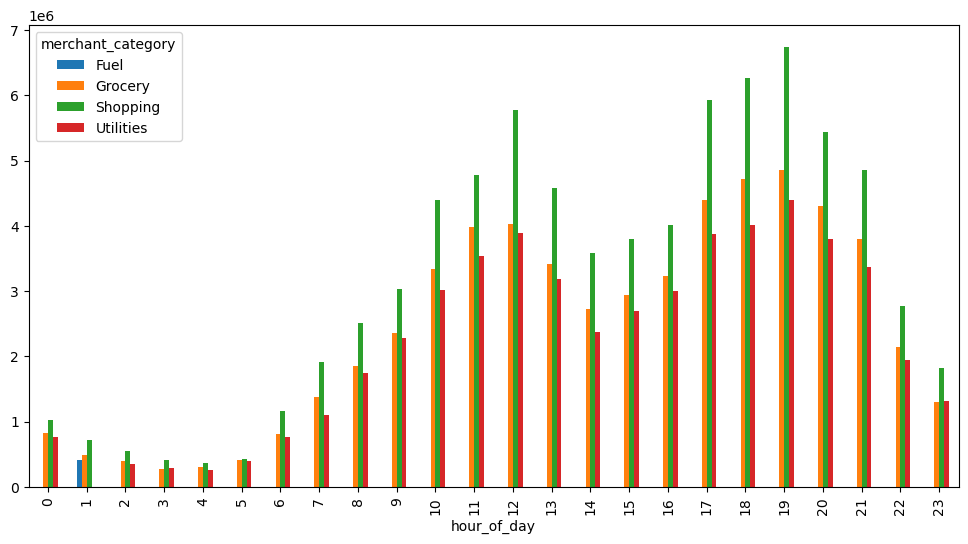

In [89]:
average_by_hour_category = df2.groupby(["hour_of_day", "merchant_category"], as_index=False)["amount (INR)"].sum().sort_values(by=["hour_of_day", "amount (INR)"], ascending=[True, False])
average_by_hour_category = average_by_hour_category.groupby("hour_of_day").head(3).pivot(index="hour_of_day", columns="merchant_category", values="amount (INR)")
average_by_hour_category.plot(kind="bar", figsize=(12, 6))

The identified 3 best performing categories are consistent in evry hour except for one, 1am, where `fuel` beats `utilities`. `shopping` tops all in every hour.

What about the last 3 performing categories, do they remain consistent throughout the hours? Analysis below

<Axes: xlabel='hour_of_day'>

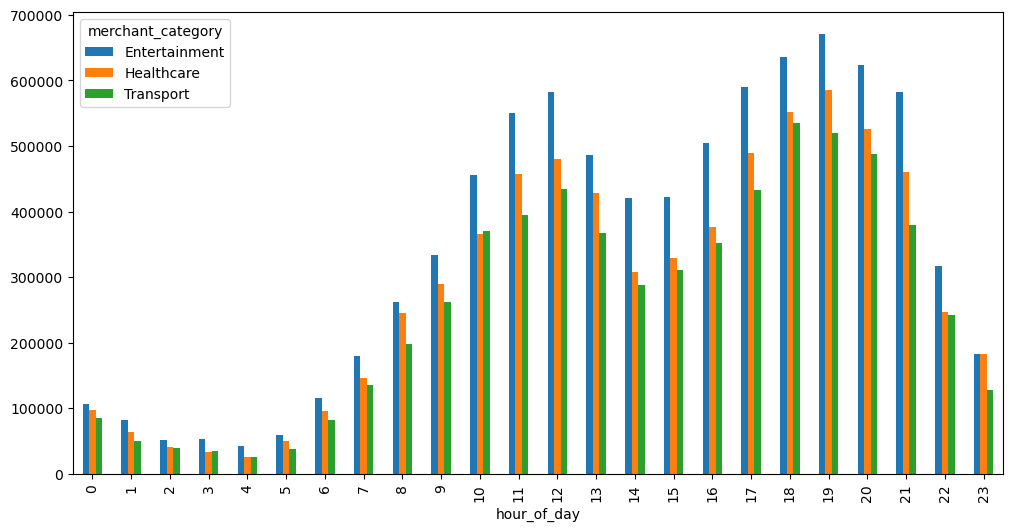

In [90]:
average_by_hour_category = df2.groupby(["hour_of_day", "merchant_category"], as_index=False)["amount (INR)"].sum().sort_values(by=["hour_of_day", "amount (INR)"], ascending=[True, True])
average_by_hour_category = average_by_hour_category.groupby("hour_of_day").head(3).pivot(index="hour_of_day", columns="merchant_category", values="amount (INR)")
average_by_hour_category.plot(kind="bar", figsize=(12, 6))

The least 3 performing categories remain consistent and `transport`, `healthcare` and `entertainment`.

### Weekend vs Weekday Comparison

<Axes: xlabel='is_weekend'>

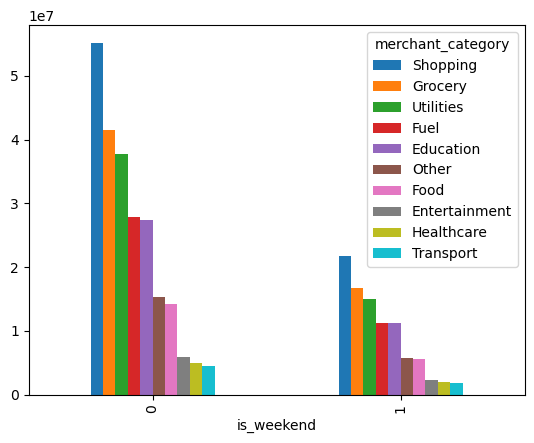

In [91]:
overall_product_performance_by_week_breakdown = df2.groupby(["is_weekend", "merchant_category"], as_index=False)["amount (INR)"].sum()
pivot_table = overall_product_performance_by_week_breakdown.pivot(index="is_weekend", columns="merchant_category", values="amount (INR)")

sorted_columns = pivot_table.sum().sort_values(ascending=False).index
pivot_table[sorted_columns].plot(kind="bar")

The order of the products performance does not change over the weekend. However the sales do.

<Axes: xlabel='merchant_category'>

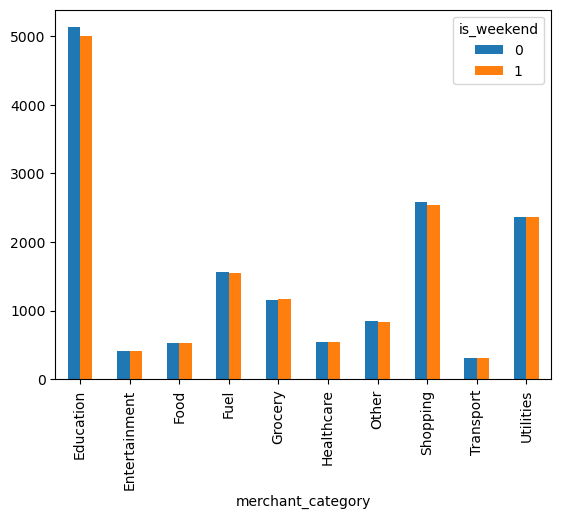

In [92]:
average_product_performance_by_week_breakdown = df2.groupby(["is_weekend", "merchant_category"], as_index=False)["amount (INR)"].mean()
pivot_table2 = average_product_performance_by_week_breakdown.pivot(index="merchant_category", columns="is_weekend", values="amount (INR)")

sorted_columns = pivot_table2.sum().sort_values(ascending=False).index
pivot_table2[sorted_columns].plot(kind="bar")

The averages of the different merchant categories for both the weekday and weekend are also closely the same, indicating that the the amounts spent by on each trasaction on the different merchant categories are almost the same. This same analysis is supported by the median plot below.

<Axes: xlabel='merchant_category'>

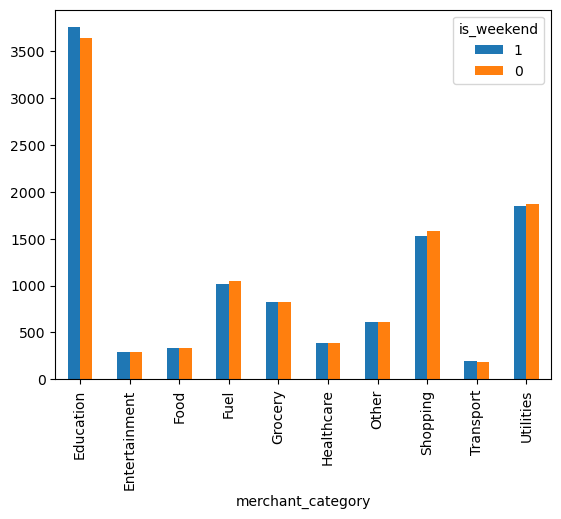

In [93]:
average_product_performance_by_week_breakdown = df2.groupby(["is_weekend", "merchant_category"], as_index=False)["amount (INR)"].median()
pivot_table2 = average_product_performance_by_week_breakdown.pivot(index="merchant_category", columns="is_weekend", values="amount (INR)")

sorted_columns = pivot_table2.sum().sort_values(ascending=False).index
pivot_table2[sorted_columns].plot(kind="bar")

### Transactions Analysis by Transaction Type

How do most payments happen?

In [94]:
df2.columns

Index(['transaction id', 'timestamp', 'transaction type', 'merchant_category',
       'amount (INR)', 'transaction_status', 'sender_age_group',
       'receiver_age_group', 'sender_state', 'sender_bank', 'receiver_bank',
       'device_type', 'network_type', 'fraud_flag', 'hour_of_day',
       'day_of_week', 'is_weekend'],
      dtype='object')

<Axes: ylabel='type_usage%'>

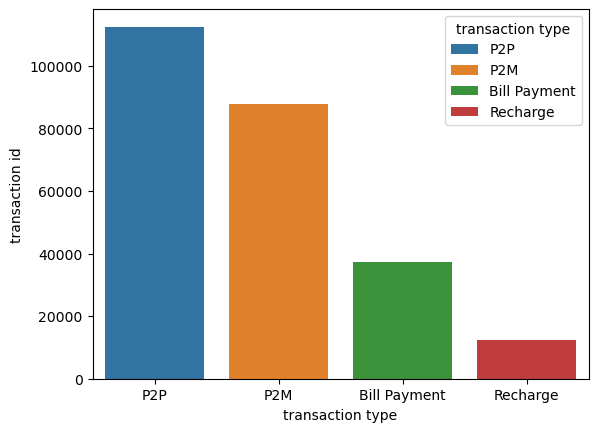

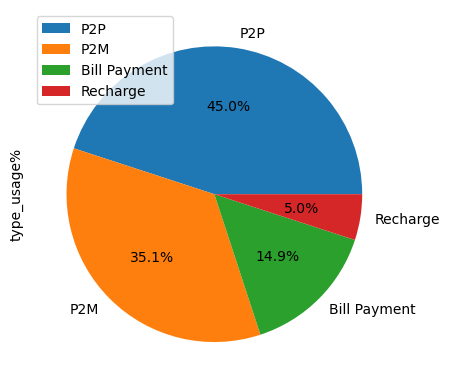

In [95]:
transactions_by_transaction_type_count = df2.groupby("transaction type")["transaction id"].count().to_frame().sort_values("transaction id", ascending=False)
sns.barplot(data=transactions_by_transaction_type_count, x="transaction type", y="transaction id", hue="transaction type", legend=True)

transactions_by_transaction_type_count["type_usage%"] = (transactions_by_transaction_type_count["transaction id"]/250000)*100

transactions_by_transaction_type_count.plot(kind="pie", y="type_usage%", autopct="%1.1f%%")

Most transactions done are from P2P (Person-to-Person).

<Axes: ylabel='type_total%'>

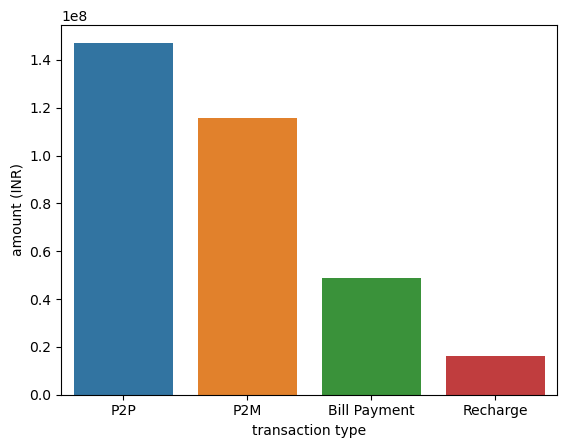

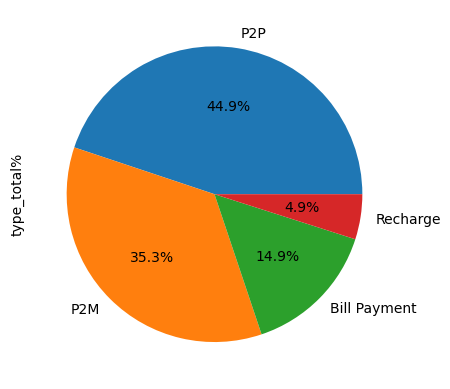

In [96]:
total_amount_by_transaction_type = df2.groupby("transaction type")["amount (INR)"].sum().to_frame().sort_values("amount (INR)", ascending=False)
sns.barplot(data=total_amount_by_transaction_type, x="transaction type", y="amount (INR)", hue="transaction type")

total_transactions_sum = total_amount_by_transaction_type.sum().iloc[0] 

total_amount_by_transaction_type["type_total%"] = (total_amount_by_transaction_type["amount (INR)"]/total_transactions_sum)*100
total_amount_by_transaction_type.plot(kind="pie", y="type_total%", autopct="%1.1f%%", legend=False)

Seems like the transactions made from each transaction type are evenly disributed just like the transactions count. This in actual normal instances would mean that the groups using both payments have matching wants and that their wants do not differ by much.

### Transactions Analysis by Age Groups and how different groups relate with different Transaction Types

In [97]:
df2.columns

Index(['transaction id', 'timestamp', 'transaction type', 'merchant_category',
       'amount (INR)', 'transaction_status', 'sender_age_group',
       'receiver_age_group', 'sender_state', 'sender_bank', 'receiver_bank',
       'device_type', 'network_type', 'fraud_flag', 'hour_of_day',
       'day_of_week', 'is_weekend'],
      dtype='object')

,transaction id,% count
sender_age_group,,
18-25,62345,100.000000
26-35,87432,140.238993
36-45,62873,100.846900
46-55,24841,39.844414
56+,12509,20.064159


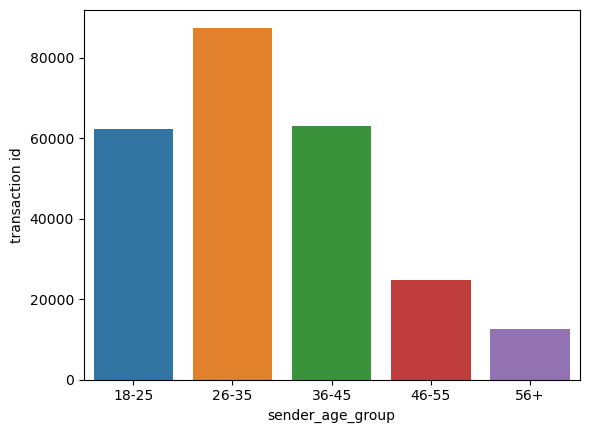

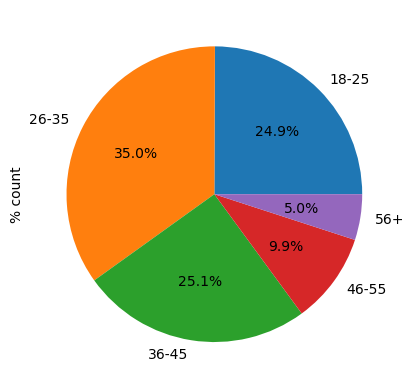

In [98]:
transactions_count_by_age = df2.groupby("sender_age_group")["transaction id"].count().to_frame()
sns.barplot(data=transactions_count_by_age, x="sender_age_group", y="transaction id", hue="sender_age_group")

transactions_count_by_age["% count"] = (transactions_count_by_age["transaction id"]/transactions_count_by_age["transaction id"].iloc[0])*100
transactions_count_by_age.plot(kind="pie", y="% count", autopct="%1.1f%%", legend=False)
transactions_count_by_age

The most active group is the group falling under the ages of 26 to 35 leading with over 80000 transactions.

<Axes: ylabel='total %'>

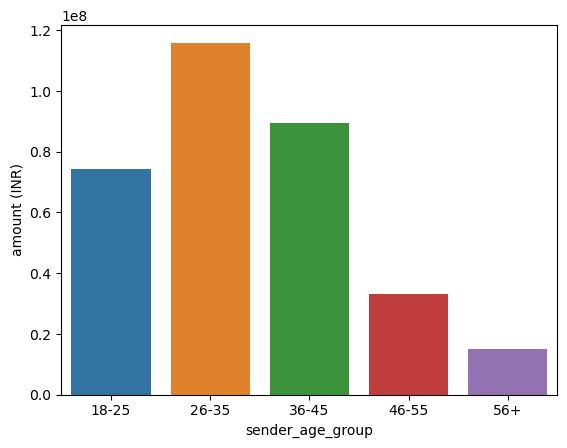

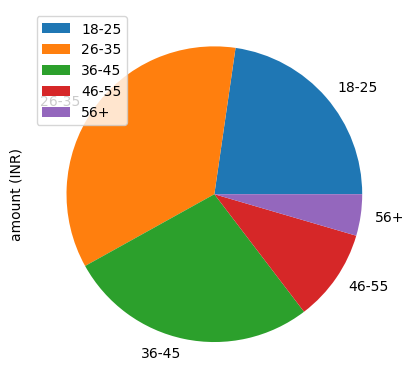

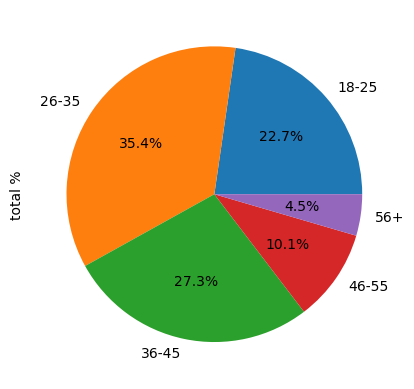

In [99]:
total_amounts_by_age = df2.groupby("sender_age_group")["amount (INR)"].sum().to_frame()
sns.barplot(data=total_amounts_by_age, x="sender_age_group", y="amount (INR)", hue="sender_age_group")

total_amounts_by_age["total %"] = (total_amounts_by_age["amount (INR)"]/total_amounts_by_age.sum().iloc[0])*100

total_amounts_by_age.plot(kind="pie", y="amount (INR)")
total_amounts_by_age.plot(kind="pie", y="total %", autopct="%1.1f%%", legend=False)

Age 26-35 remains as top in terms of the the total amount transacted. But here, the close tie between age 18-25 and age 36-45 is broken seeing that the age 36-45 transacted more amounts that age 18-25.

Below, we go doen to the most preferred transactions types by the different ages.

<Axes: xlabel='sender_age_group'>

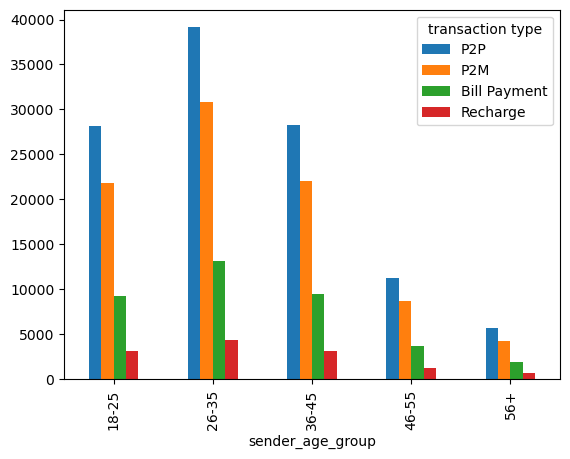

In [100]:
transaction_types_by_age = df2.groupby(["sender_age_group", "transaction type"], as_index=False)["transaction id"].count()
pivot_table3 = transaction_types_by_age.pivot(index="sender_age_group", columns="transaction type", values="transaction id")

sorted_columns2 = pivot_table3.sum().sort_values(ascending=False).index
pivot_table3[sorted_columns2].plot(kind="bar")

All payment types across all the present age groups have their preferred transaction types in the order P2P, P2M, Bill Payment and Recharge.

# Conclusion
Having done an analysis on this data, I come to the following conclusions:
1. The frequency with which the Indian people transact follows a certain trend throughout the hours. decreasing(0000hrs-0400hrs) to reach it's lowest, increasing(0500hrs-1200hrs) to reach it's second highest value within the day, decreasing(1300hrs-1400hrs) to reach it's second higher low, increasing(1500hrs-1900hrs) to reach it's highest for the day, then finally decreasing from there to 2300 hrs.
- This has been supported by various factors such as; having almost level average amounts spending throughout the day which gives us the quality of our trend analysis, the median values for every hour are within the same range further confirming and giving ue the counlution of this finding.
- The outliers found in the dataset are distributed almost evenly across the hours, hence why we had closely matching averages with the difference between the lowest average point and the highest average point not exceeding 150 INR.

2. The leading 3 merchant categories where transactions were directed to were `shopping`, `grocery` and `utilities` and the trailing 3 were `shopping`, `grocery` and `utilities`. This remains consistent through the hourly datasetexcept for one instance, 1am, where the `fuel` category beats the `utilities` category.

3. The difference between the transactions happening during the weekdays and the weekends only hugely differ by sum of the amounts transacted and not by differing weights on categories spent on. The order in which the different categories are distributed within the weekdays is the same as the weekends, no change. The averages of the amounts spent, which would show the different categories valued in the weekdays and the weekend and their difference, are closely within the same ranges. Showing that their behavior on spending remains intact throughout the week(s).

4. The most used transaction type is P2P with 45% usage followed by the others in this order, P2M (35%), Bill Payment(15%), Recharge(5%). These %age closely match with the %age total amounts transacted through. Generally, the payment options are distributed to everyone in those %ages and no certain groups, by status, are limited to certain payment types.

5. Finally the age group that transacts the most is 26-35(35%) years. Ages 18-25(24.9%) and 36-45 almost have a tie but ages 36-45(25.1%) have the lead by a small margin,which are then followed ages 45-55(9.9%) and 56+(5%) respectively.
- The amounts plots, show us that 26-35(35.4%) years transact the most amounts of money followed by ages 36-45(27.3%) (with a noticeable difference from the amounts transacted by ages 18-25), then ages 18-25(22.7%), then 45-55(10.1%) and finally 56+(4.5%).

6. DO different age groups prefer different transaction types that others? Well, according to the data, the different transaction types follow the findings in point 4 across all age groups.